In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

file_path=r"C:\Users\sutir\OneDrive\Desktop\Rot_curve\Cepheids_Gaia (1).csv"
cep=pd.read_csv(file_path)
ra_array = np.array(cep['ra']) * u.degree
dec_array = np.array(cep['dec']) * u.degree
distance_array = (np.array(cep['parallax']) * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = np.array(cep['pmra']) * u.mas / u.yr
pm_dec_array = np.array(cep['pmdec']) * u.mas / u.yr
radial_velocity_array = np.array(cep['radial_velocity']) * u.km / u.s
l=np.array(cep['l']) * u.degree
b=np.array(cep['b']) * u.degree 




'''cep=np.loadtxt('GC.txt')
ra_array = cep[1:, 2]* u.degree
dec_array =cep[1:, 3] * u.degree
distance_array = (cep[1:, 1] * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec_array = cep[1:, 5] * u.mas / u.yr
pm_dec_array = cep[1:, 6] * u.mas / u.yr
radial_velocity_array = cep[1:, 4] * u.km / u.s
l=cep[1:, 7] * u.degree
b=cep[1:, 8]* u.degree '''


# Constants
U_sun, V_sun, W_sun = 11.1* u.km / u.s, 12.24* u.km / u.s, 7.25* u.km / u.s  # Solar motion (km/s)
V0 = 233   * u.km / u.s  # Galactic rotation speed (km/s)
R0 = 8.0 * u.kpc

# Function to transform coordinates
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity,l,b):
    c = SkyCoord(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pm_ra_cosdec,
                 pm_dec=pm_dec, radial_velocity=radial_velocity)
    g = c.transform_to(Galactocentric(galcen_distance=8.0 * u.kpc,  # Default distance to Galactic Center
                                      z_sun=0.020 * u.kpc,  # Default Sun's height above the Galactic plane
                                      galcen_v_sun=[11.1,12.24, 7.25] * (u.km / u.s)))
    
    x, y, z = g.x.value, g.y.value, g.z.value
    v_x, v_y, v_z = g.v_x.value, g.v_y.value, g.v_z.value
    d=distance
    # Convert to cylindrical coordinates
    R = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    v_R = (x * v_x + y * v_y) / R
    v_phi = (x * v_y - y * v_x) / R
    r=np.sqrt(R0**2 + d**2 - 2 * R0 * d * np.cos(b) * np.cos(l))
    v_gsr=radial_velocity + U_sun * np.cos(b) * np.cos(l) + \
           V_sun * np.cos(b) * np.sin(l) + \
           W_sun * np.sin(b) + V0 * np.cos(b) * np.sin(l)
    Rp=np.sqrt(R0**2 + d**2*np.cos(b)**2 - 2 * R0 * d * np.cos(b) * np.cos(l))
    v_lsr=radial_velocity + (U_sun * np.cos(b) * np.cos(l)) + (V_sun * np.cos(b) * np.sin(l)) +( W_sun * np.sin(b)) 

    v_c=(Rp/R0)*((v_lsr/(np.sin(l)*np.cos(b)))+V0)
    

    return np.array([R, phi, z, v_R, v_phi, v_z, np.abs(z),r,v_gsr,Rp,v_c])
#plt.scatter((transform_to_galactocentric(ra_array,dec_array,distance_array,pm_ra_cosdec_array,pm_dec_array,radial_velocity_array)[0]),(transform_to_galactocentric(ra_array,dec_array,distance_array,pm_ra_cosdec_array,pm_dec_array,radial_velocity_array)[3]),s=1)


(-500.0, 500.0)

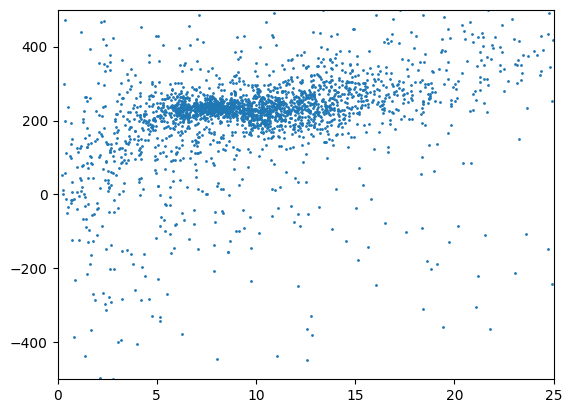

In [12]:
x = (transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[0])
y = (transform_to_galactocentric(ra_array, dec_array, distance_array, pm_ra_cosdec_array, pm_dec_array, radial_velocity_array, l, b)[10])
plt.scatter(x,y,s=1)
plt.xlim(0,25)
plt.ylim(-500,500)

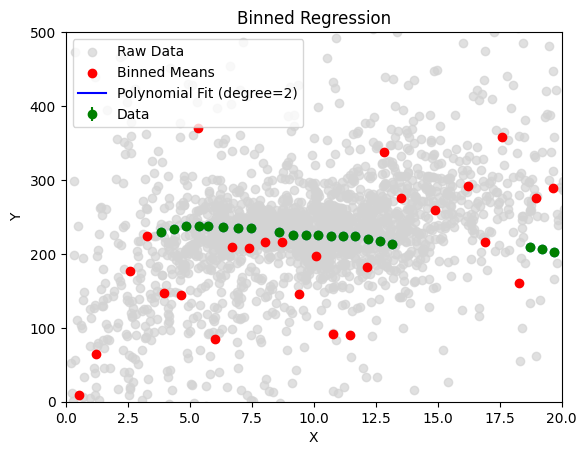

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def binsreg(x, y, bins=10, degree=1):
    """
    Perform binning-based regression.

    Parameters:
    - x: Array-like, independent variable.
    - y: Array-like, dependent variable.
    - bins: Number of bins or custom bin edges.
    - degree: Degree of the polynomial regression.

    Returns:
    - bin_centers: Centers of the bins.
    - bin_means: Mean values of y in each bin.
    - fit_params: Fitted polynomial coefficients.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Omit NaN values
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]

    # Define bin edges
    if isinstance(bins, int):
        bin_edges = np.linspace(np.min(x), np.max(x), bins + 1)
    else:
        bin_edges = np.asarray(bins)

    bin_centers = []
    bin_means = []

    for i in range(len(bin_edges) - 1):
        bin_mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        if np.any(bin_mask):
            bin_centers.append((bin_edges[i] + bin_edges[i + 1]) / 2)
            bin_means.append(np.mean(y[bin_mask]))

    bin_centers = np.array(bin_centers)
    bin_means = np.array(bin_means)

    # Fit polynomial to binned data
    fit_params = np.polyfit(bin_centers, bin_means, degree)

    return bin_centers, bin_means, fit_params

def plot_binsreg(x, y, bin_centers, bin_means, fit_params, degree):
    """
    Plot the binned data and the fitted regression line.

    Parameters:
    - x: Array-like, independent variable.
    - y: Array-like, dependent variable.
    - bin_centers: Centers of the bins.
    - bin_means: Mean values of y in each bin.
    - fit_params: Fitted polynomial coefficients.
    - degree: Degree of the polynomial regression.
    """
    plt.scatter(x, y, color='lightgray', alpha=0.7, label='Raw Data')
    plt.scatter(bin_centers, bin_means, color='red', label='Binned Means')

    # Generate polynomial fit line
    x_fit = np.linspace(np.min(x), np.max(x), 500)
    y_fit = np.polyval(fit_params, x_fit)
    plt.plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit (degree={degree})')
    data1 = np.loadtxt('RV+Eilers.txt')
        


        # Extract x and y columns
    x1, y1,e1 = data1[:, 0], data1[:, 1] ,data1[:,2]

        # Plot the data
# Plotting


    plt.scatter(x1, y1)
    plt.errorbar(x1, y1,yerr=e1, fmt='o', color='g', label='Data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Binned Regression')
    plt.ylim(0,500)
    plt.xlim(0,20)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
 

    

    # Perform binsreg
    bin_centers, bin_means, fit_params = binsreg(x, y, bins=9000, degree=2)

    # Plot results
    plot_binsreg(x, y, bin_centers, bin_means, fit_params, degree=2)



c:\Python311\Lib\site-packages\binsreg\binsreg.py:1520: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


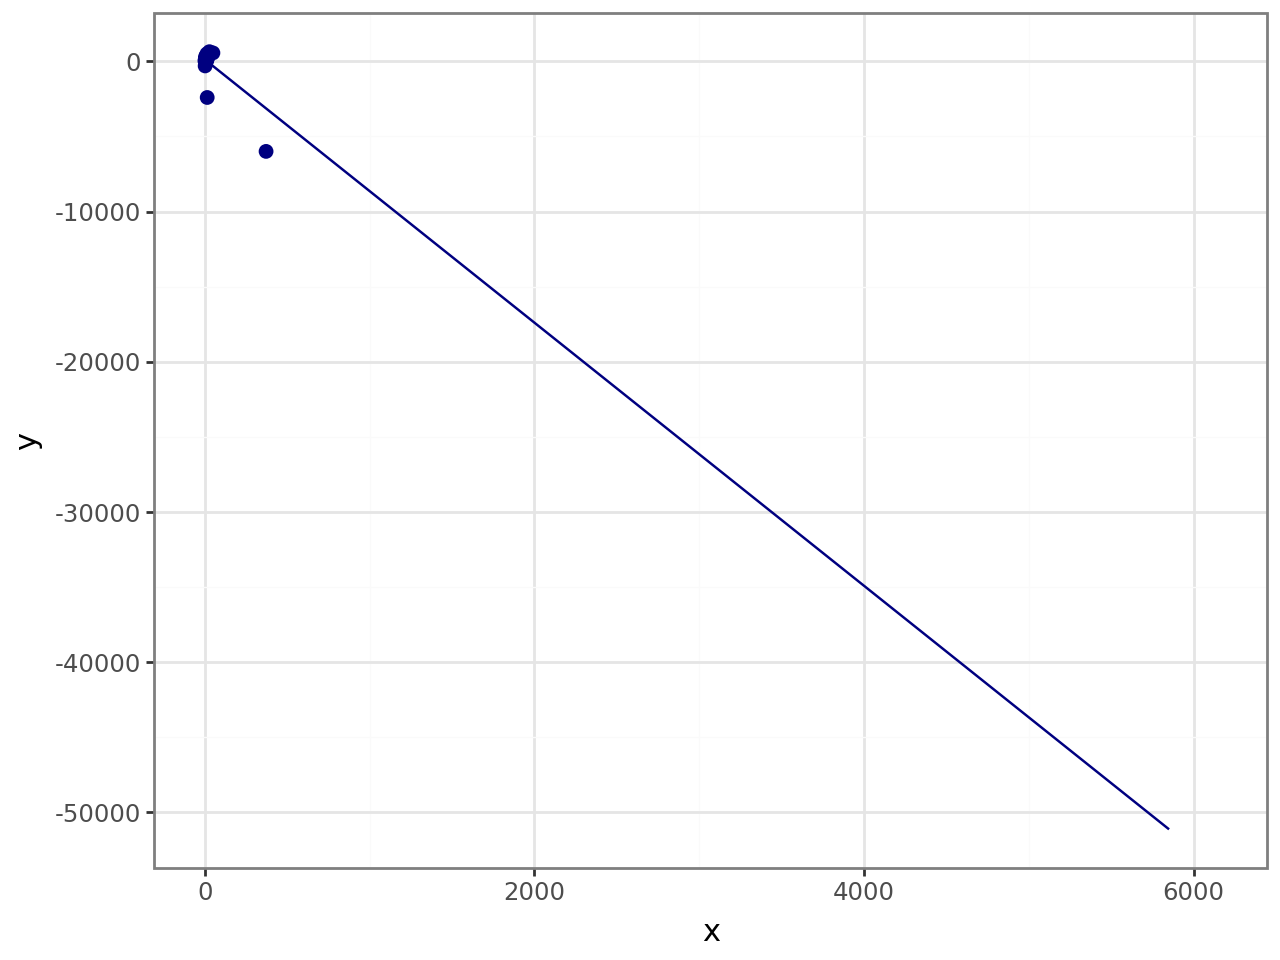

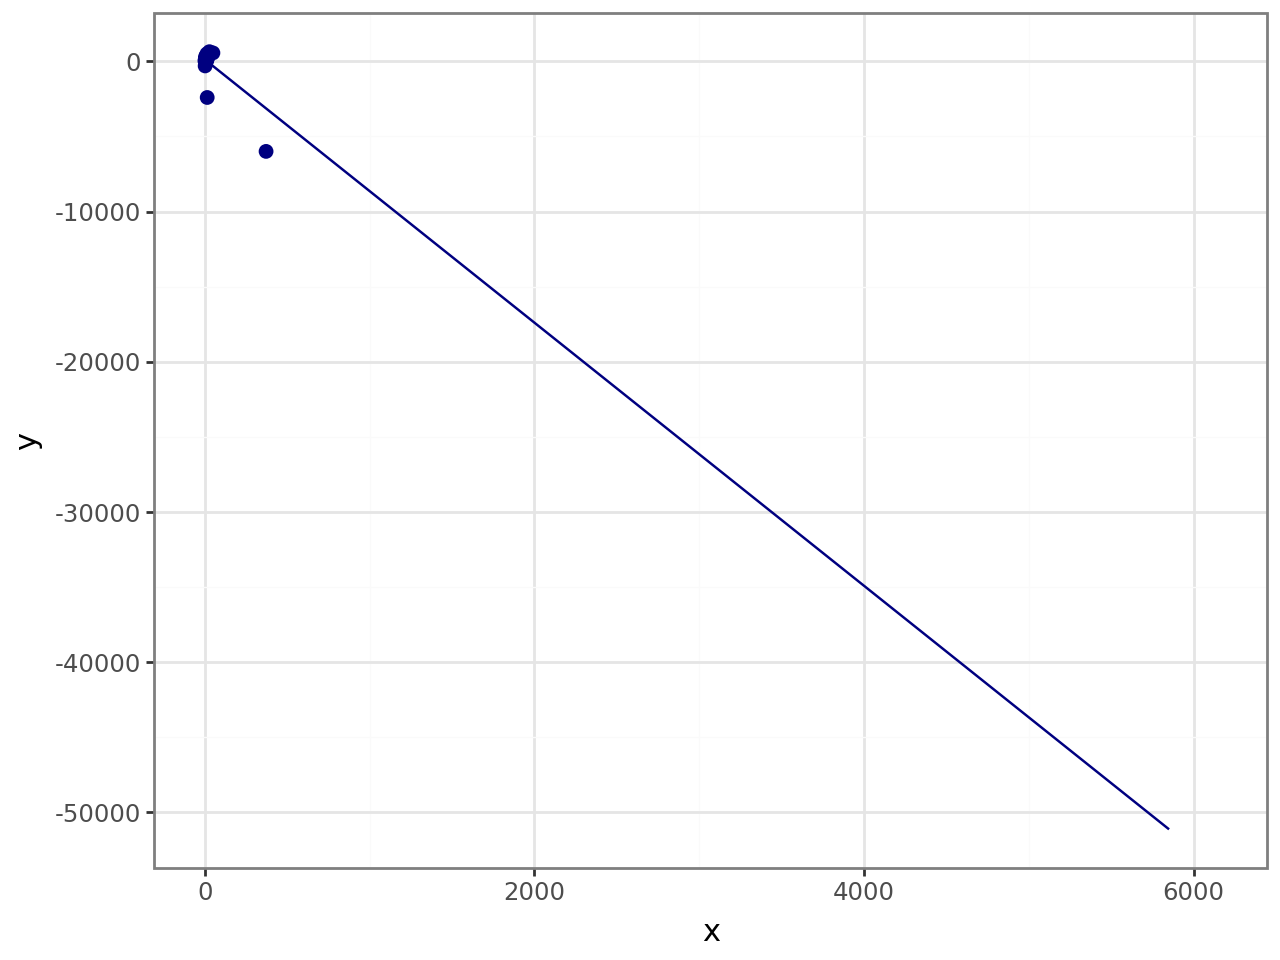

In [13]:
import numpy as np
import seaborn as sns
from binsreg import binsreg



est = binsreg(y, x,  nbins=30, polyreg=1)
est.bins_plot

C:\Users\sutir\AppData\Local\Temp\ipykernel_25204\462397165.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['bin'] = pd.cut(filtered_data['x'], bins=np.linspace(x_min, x_max, num_bins + 1))
C:\Users\sutir\AppData\Local\Temp\ipykernel_25204\462397165.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_data.groupby('bin')


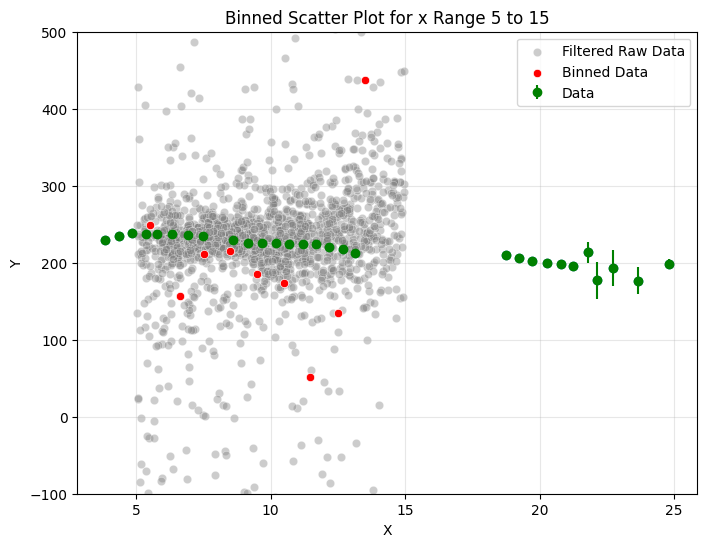

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.DataFrame({'x': x, 'y': y})

# Filter data for a specific range of x (e.g., 20 to 80)
x_min, x_max = 5, 15
filtered_data = data[(data['x'] >= x_min) & (data['x'] <= x_max)]

# Define the number of bins within the range
num_bins = 10
filtered_data['bin'] = pd.cut(filtered_data['x'], bins=np.linspace(x_min, x_max, num_bins + 1))

# Aggregate data within bins
binned_data = (
    filtered_data.groupby('bin')
    .agg({'x': 'mean', 'y': 'mean'})
    .reset_index(drop=True)  # Drop the bin index
)
plt.figure(figsize=(8, 6))
# Plot using seaborn

data1 = np.loadtxt('RV+Eilers.txt')
        


        # Extract x and y columns
x1, y1,e1 = data1[:, 0], data1[:, 1] ,data1[:,2]

        # Plot the data
# Plotting


plt.scatter(x1, y1)
plt.errorbar(x1, y1,yerr=e1, fmt='o', color='g', label='Data')

sns.scatterplot(data=filtered_data, x='x', y='y', alpha=0.4, label='Filtered Raw Data', color='gray')
sns.scatterplot(data=binned_data, x='x', y='y', color='red', label='Binned Data', zorder=5)

# Add labels and legend
plt.title(f'Binned Scatter Plot for x Range {x_min} to {x_max}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(-100,500)
plt.show()


c:\Python311\Lib\site-packages\binsreg\binsreg.py:1520: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


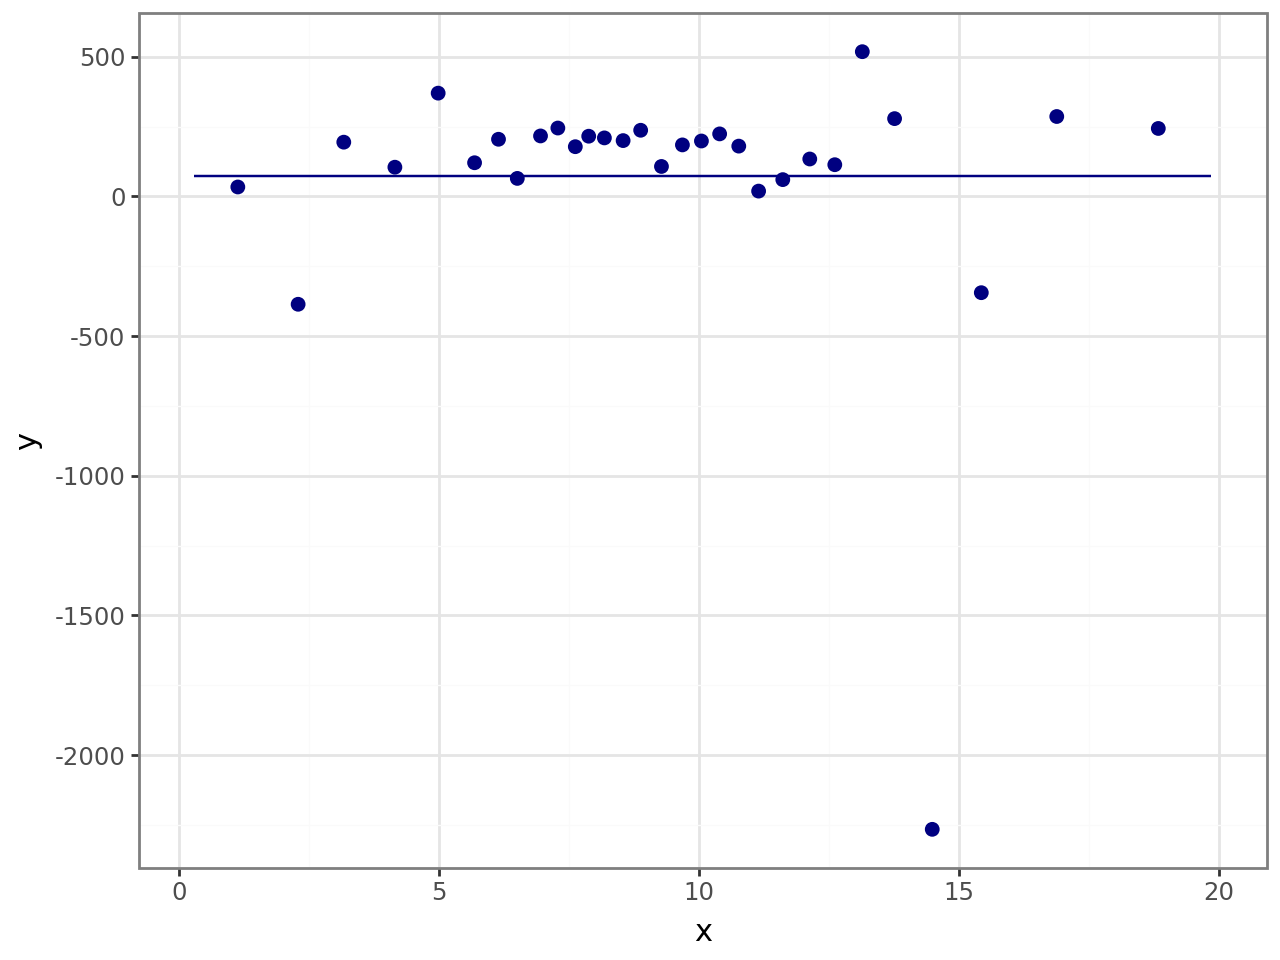


Call: binsreg

Binscatter Plot
Bin/Degree selection method (binsmethod) =                          User-specified
Placement (binspos)                      =                         Quantile-spaced
Derivative (deriv)                       =                                       0
 
Group (by)                               =                             Full Sample
Sample size (n)                          =                                    2542
# of distinct values (Ndist)             =                                    2542
# of clusters (Nclust)                   =                                     nan
dots, degree (p)                         =                                       0
dots, smooth (s)                         =                                       0
# of bins (nbins)                        =                                      30




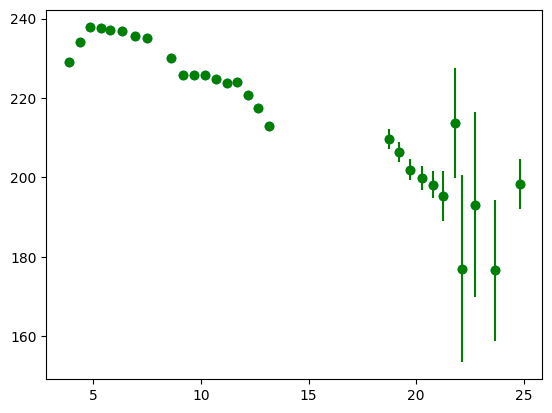

<Figure size 800x600 with 0 Axes>

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from binsreg import binsreg

data1 = np.loadtxt('RV+Eilers.txt')
        


        # Extract x and y columns
x1, y1,e1 = data1[:, 0], data1[:, 1] ,data1[:,2]

        # Plot the data
# Plotting


plt.scatter(x1, y1)
plt.errorbar(x1, y1,yerr=e1, fmt='o', color='g', label='Data')
# Filter data for a specific range of x (e.g., 20 to 80)
x_min, x_max = 0,20
filtered_indices = (x >= x_min) & (x <= x_max)
x_filtered = x[filtered_indices]
y_filtered = y[filtered_indices]

# Create binned scatter plot with error bars using binsreg
plt.figure(figsize=(8, 6))

binsreg(x=x_filtered, y=y_filtered, nbins=30,  polyreg=0)




